In [1]:
from tensorflow.keras import datasets, layers, models

import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [81]:
def padImage(image, pixels=5, pad_sides=True):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    if pad_sides:
        img = np.insert(img, [0], [0] * pixels, 1)
        img = np.insert(img, [-1], [0] * pixels, 1)
    return img

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = (train_images / 255.0).astype(np.float32), test_images.astype(np.float32) / 255.0

11493376/11490434 [==============================] - 2s 0us/step


In [4]:
### THE PAD HAS TO BE DONE IN THE
### POLAR SPACE

# 20 is the ceiling of (14 * sqrt(2))
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in train_images]
X_train_polar = [padImage(x, pixels=5) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)[...,None]

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)[...,None]

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)[...,None]

In [342]:
model = models.Sequential()
model.add(layers.Input(shape=X_train_polar.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [343]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_polar, train_labels, batch_size=32, epochs=10, 
          validation_data=(X_test_r_polar, test_labels),
          callbacks=[reduce_lr])

Epoch 1/10
1875/1875 [==============================] - 116s 61ms/step - loss: 0.9180 - accuracy: 0.6921 - val_loss: 0.5734 - val_accuracy: 0.8501
Epoch 2/10
1875/1875 [==============================] - 115s 61ms/step - loss: 0.1559 - accuracy: 0.9515 - val_loss: 0.6110 - val_accuracy: 0.8314
Epoch 3/10
1875/1875 [==============================] - 270s 144ms/step - loss: 0.1279 - accuracy: 0.9600 - val_loss: 0.4672 - val_accuracy: 0.8544
Epoch 4/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.1095 - accuracy: 0.9667 - val_loss: 0.4445 - val_accuracy: 0.8683
Epoch 5/10
1875/1875 [==============================] - 115s 61ms/step - loss: 0.0948 - accuracy: 0.9696 - val_loss: 0.4897 - val_accuracy: 0.8563
Epoch 6/10
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0900 - accuracy: 0.9718 - val_loss: 0.5578 - val_accuracy: 0.8460
Epoch 7/10
1875/1875 [==============================] - 1117s 596ms/step - loss: 0.0867 - accuracy: 0.9728 - val_loss

In [7]:
# Plain accuracy
accuracy = np.mean(model.predict(X_test_polar).argmax(axis=1) == test_labels)*100
# "Rotated" accuracy
accuracy_rotated = np.mean(model.predict(X_test_r_polar).argmax(axis=1) == test_labels)*100

print(accuracy, accuracy_rotated)

98.42 87.21


In [8]:
import matplotlib.pyplot as plt

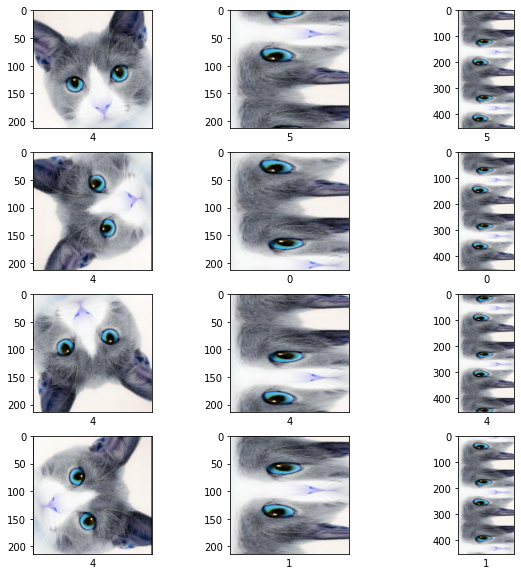

In [263]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 3
a = [0, np.pi/2, np.pi, np.pi/2+np.pi]
img_4 = np.where(train_labels == 4)[0][0]
bgr_cat = cat[:,:,[2,1,0]]
for i in range(4):
    col3 = ((i+1)*cols)
    col2 = col3-1
    col1 = col2-1
    
    rot_img_4 = tfa.image.rotate(bgr_cat, a[i]).numpy()
    #cv.imwrite(f'cat_{i}.png', (rot_img_4 * 255).astype(np.int64))
    max_r = np.sqrt(np.sum((np.array(rot_img_4.shape)[:-1])**2))/2 - 46
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2)[:-1], max_r, cv.WARP_FILL_OUTLIERS)  
    #cv.imwrite(f'cat_polar_{i}.png', (pol_img_4 * 255).astype(np.int64))
    pol_pad_img_4 = padImage(pol_img_4, pixels=120, pad_sides=False)
    #cv.imwrite(f'cat_polNpad_{i}.png', (pol_pad_img_4 * 255).astype(np.int64))
    
    
    # Normal
    plt.subplot(rows,cols,col1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(rot_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    # Polar
    plt.subplot(rows,cols,col2)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Polar & Pad
    plt.subplot(rows,cols,col3)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
plt.show()

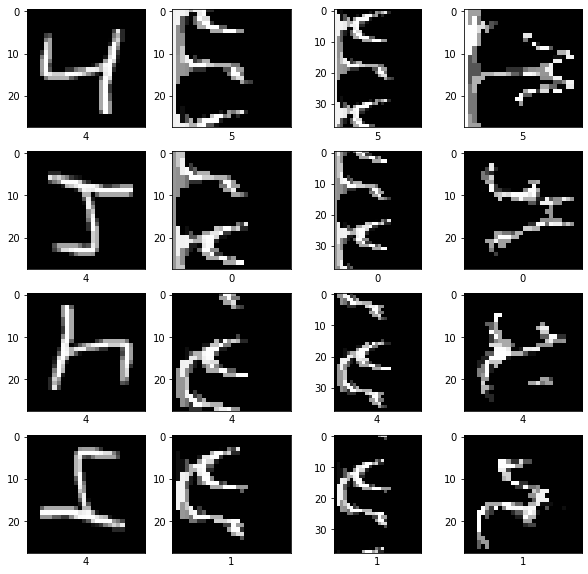

In [88]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 4
a = [0, np.pi/2, np.pi, np.pi/2+np.pi]
img_4 = np.where(train_labels == 4)[0][0]

for i in range(4):
    col4 = ((i+1)*cols)
    col3 = col4-1
    col2 = col3-1
    col1 = col2-1
    
    rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)    
    pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)
    pol_pol = cv.linearPolar(pol_img_4, tuple(np.array(pol_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)
    
    # Normal
    plt.subplot(rows,cols,col1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(rot_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    # Polar
    plt.subplot(rows,cols,col2)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Polar & Pad
    plt.subplot(rows,cols,col3)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Double Polar
    plt.subplot(rows,cols,col4)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pol, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    
plt.show()

In [198]:
cat = np.asarray(Image.open('cat_before.JPG'))
cat = cat/255.0

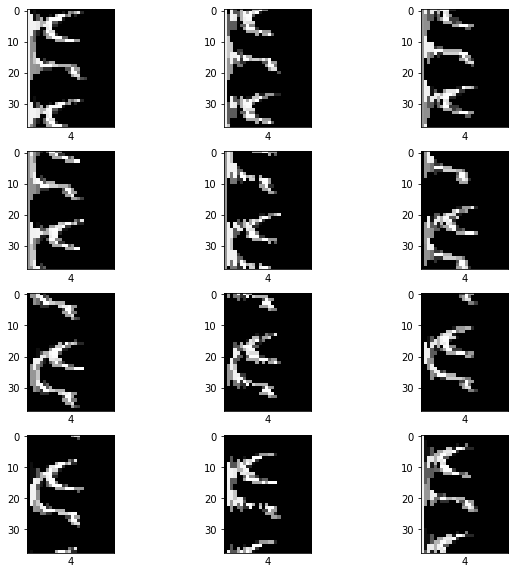

In [194]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 3
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
img_4 = np.where(train_labels == 4)[0][0]

for i in range(12):
    rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
    #cv.imwrite(f'cat_{i}.png', (rot_img_4 * 255).astype(np.int64))
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
    #cv.imwrite(f'cat_polar_{i}.png', (pol_img_4 * 255).astype(np.int64))
    pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)
    cv.imwrite(f'4_12samples_polNpad_{i}.png', (pol_pad_img_4 * 255).astype(np.int64))
    
    
    # Rots
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    
plt.show()

In [546]:
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
class_box = []
class_preds = []
for j in range(10): 
    imgj = train_images[np.where(train_labels==j)[0][0]]
    padded_imgs = []
    for i in range(12):
        rot_img = tfa.image.rotate(imgj, a[i]).numpy()
        max_r = np.sqrt(np.sum((np.array(rot_img.shape))**2))/2
        pol_img = cv.linearPolar(rot_img, tuple(np.array(rot_img.shape)/2), max_r, cv.WARP_FILL_OUTLIERS)
        pol_pad_img = padImage(pol_img, pixels=5, pad_sides=True)
        padded_imgs.append(pol_pad_img)
    class_box.append(np.asarray(padded_imgs))
    class_preds.append(model.predict(np.expand_dims(class_box[-1], axis=-1)))
class_box = np.asarray(class_box)
class_preds = np.asarray(class_preds)

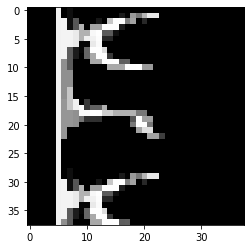

In [542]:
plt.imshow(class_box[4][0], cmap=plt.cm.binary_r)

In [385]:
preds = model.predict(np.expand_dims(padded_imgs, axis=-1))
np.argmax(preds,axis=1), np.std(preds[:,6])

(array([4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 2, 4], dtype=int64), 0.00031451206)

In [405]:
x = model.layers[0](np.expand_dims(np.asarray(padded_imgs),axis=-1))
x = model.layers[1](x)
x = model.layers[2](x)
x = model.layers[3](x)
x = model.layers[4](x)
x = model.layers[5](x)
x = model.layers[6](x)
x = model.layers[7](x)
x = model.layers[8](x)
x = model.layers[9](x)

In [414]:
x

TensorShape([12, 128])

In [467]:
x1 = np.reshape(x, (128,12))

In [485]:
x1[0]

array([ 2.0369673, 11.848951 , 12.612136 ,  6.2657995,  7.8025737,
        0.       ,  5.456728 ,  3.1214795,  9.422589 ,  0.       ,
        5.483698 ,  3.1797452], dtype=float32)

In [486]:
np.std(x[:,11])

1.8195758

In [632]:
devi = []
conf = []
x_ind = list(range(10))
for i in range(10):
    devi.append(np.std(class_preds[4][:,i]))
    conf.append(np.std(class_preds[i][:,4]))

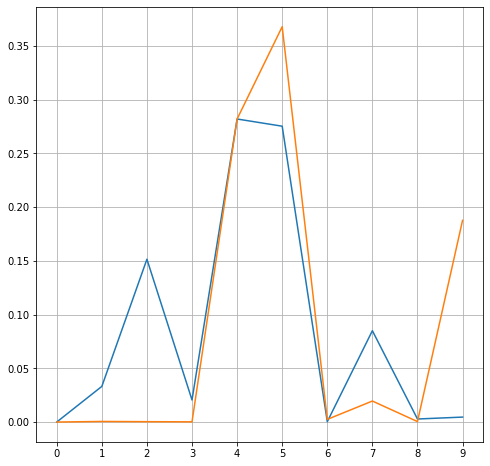

In [678]:
plt.figure(figsize=(8,8))
plt.grid(True)
plt.plot(devi,label='ok')
plt.plot(conf)
plt.xticks(x_ind)
plt.show()

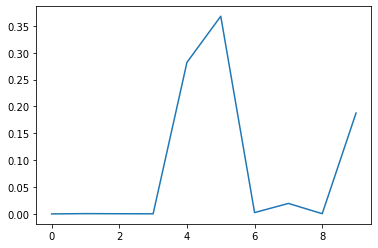

In [650]:
plt.plot(conf)

In [14]:
class node:
    def __init__(self, val):

       self.val = val
       self.nextNode = None

    def __repr__(self):
       return "%s" % self.val

In [15]:
class linkedList:
    def __init__(self):
       self.head = None

    def addNode(self, nodeVal):
       if self.head is None:
           self.head = nodeVal
       else:
           tmp = self.head
           while tmp.nextNode is not None:
               tmp = tmp.nextNode
           tmp.nextNode = nodeVal

    def linkNode(self, node):
       if self.head is None:
           raise Exception("list can't be None")
       tmp = self.head
       while tmp.nextNode is not None:
           tmp = tmp.nextNode
       tmp.nextNode = node

    def __repr__(self):           
       tmp = self.head
       val = []
       while tmp is not None:
           val.append(tmp.val)
           tmp = tmp.nextNode
       return "vals are %s" % val

In [16]:
s = linkedList()
head = node(0)
node1 = node(1)
node2 = node(2)
node3 = node(3)
node4 = node(4)
node5 = node(5)
s.addNode(head)
s.addNode(node1)
s.addNode(node2)
s.addNode(node3)
s.addNode(node4)
s.addNode(node5)
s.linkNode(node2)

In [17]:
tmp = s.head
for i in range(10):
    print(tmp.val)
    tmp = tmp.nextNode

0
1
2
3
4
5
2
3
4
5
